# **Introduction**

Texte introductif sur notre sujet, notre problématique, notre plan (angles d'attaque, études menées, bases de données utilisées)

# **I. Préparation de l'espace de travail**

## **1. Importations des modules et bibliothèques**

### **1.a. Bibliothèques de base.**

In [ ]:
# Installation des modules nécessaires à l'exécution du code

!pip install openpyxl cartiflette mapclassify

In [ ]:
# Import des bibliothèques utilisés pour la lecture des données et les statistiques descriptives 

import openpyxl 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from cartiflette import carti_download
import mapclassify
import plotly.express as px

### **1.b. Bibliothèques liées à la modélisation**

In [164]:
import sklearn.metrics
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import lasso_path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV

## **2. Lecture et nettoyage des différentes bases de données**

### **2.a. Base de la démographie des médecins : demographie_medecins.xslx**

In [ ]:
# Import des bases de données depuis "Bases de données/"

df_medecins_effectif_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=1)
df_medecins_age_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=2)
df_medecins_densite_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=3)
df_medecins_secteur = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=6)

In [ ]:
# Création de plusieurs bases de données réduites (MG = médecins généralistes).

# 1. Base des effectifs des médecins généralistes.
df_MG_effectif = df_medecins_effectif_complet[
    (df_medecins_effectif_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_effectif_complet['specialites'] == '00-Ensemble')
    ]

df_MG_effectif.drop(axis = 1, columns = ['specialites', 'specialites_agregees'], inplace = True)
df_MG_effectif.reset_index(drop = True, inplace = True)

# 2. Base des âges moyens des médecins généralistes (ici, on ne considérera pas le sexe).
df_MG_age = df_medecins_age_complet[
    (df_medecins_age_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_age_complet['sexe'] == '0-Ensemble')
    & (df_medecins_age_complet['specialites'] == '00-Ensemble')
    ]

df_MG_age.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_MG_age.reset_index(drop = True, inplace = True)

# 3. Base des densités de médecins généralistes (ici, on ne considérera pas le sexe).
df_MG_densite = df_medecins_densite_complet[
    (df_medecins_densite_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_densite_complet['sexe'] == '0-Ensemble')
    & (df_medecins_densite_complet['specialites'] == '00-Ensemble')
]

df_MG_densite.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_MG_densite.reset_index(drop = True, inplace = True)

### **2.b. Base de l'indicateur APL (Accessibilité Potentielle Localisée) : APL_2015_2022.xlsx et APL_2022_2023.xlsx**

Cet indicateur est une mesure de l'accessibilité aux médecins libéraux, qui tient compte du niveau d'activité des médecins (offre) et du niveau de recours de la population (demande). Cet indicateur est construit au niveau communal mais prend en compte l'offre et la demande des communes voisines, dans un certain périmètre.
Pour son calcul, on définit une zone de recours et une zone de patientèle. Les médecins sont comptés en ETP (équivalent temps plein), afin de prendre en compte leur activité annuelle.
L'APL nous donne finalement le nombre d'ETP des médecins généralistes libéraux pour 100 000 habitants.
Les données de 2015 à 2021 n'utilisent pas exactement la même méthode que de 2022 à 2023, donc ces données ne sont pas parfaitement comparables.

In [ ]:
# Lecture des feuilles de la table APL_2022_2023 : valeurs de l'indicateur en 2022 et 2023.
df_APL_2022 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=1)[8:]
df_APL_2023 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=2)[8:]

# Lecture des feuilles de la table APL_2015_2022 (on exclut l'année 2022 en considérant que les données de APL_2022_2023 sont plus pertinentes)
df_APL_2015 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=1)[8:]
df_APL_2016 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=2)[8:]
df_APL_2017 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=3)[8:]
df_APL_2018 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=4)[8:]
df_APL_2019 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=5)[8:]
df_APL_2021 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=6)[8:]

In [125]:
# Nettoyage et renommage des colonnes des bases 2022 et 2023.
bases = [df_APL_2022, df_APL_2023]
annee = 2022

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"APL_{annee}_moins_62", f"APL_{annee}_moins_60", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1

# Nettoyage et renommage des colonnes des bases 2015 à 2021.
bases = [df_APL_2015,df_APL_2016,df_APL_2017,df_APL_2018,df_APL_2019,df_APL_2021]
annee = 2015

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1
    if annee == 2020 : 
        annee += 1

# Jointure des bases en une base APL commune.
bases.append(df_APL_2022)
df_APL = df_APL_2023
for base in bases : 
    df_APL = df_APL.merge(base, how='left', on=["Code commune INSEE", "Commune"])

df_APL

,Code commune INSEE,Commune,APL_2023,APL_2023_moins_65,APL_2023_moins_62,APL_2023_moins_60,population_standard_2021,population_totale_2021,APL_2015,APL_2015_moins_65,...,APL_2021,APL_2021_moins_65,population_standard_2019,population_totale_2019,APL_2022,APL_2022_moins_65,APL_2022_moins_62,APL_2022_moins_60,population_standard_2020,population_totale_2020
0,01001,L'Abergement-Clémenciat,1.942,1.881,1.623,1.455,838.154,832,NaN,NaN,...,2.15,2.076,775.023,779,1.89,1.828,1.799,1.491,810.855,806
1,01002,L'Abergement-de-Varey,2.376,1.767,1.503,1.333,255.723,267,NaN,NaN,...,2.505,2.19,252.742,256,2.649,2.059,1.83,1.493,250.962,262
2,01004,Ambérieu-en-Bugey,3.083,2.431,2.136,1.855,14575.887,14854,4.42,4.324,...,3.367,3.102,13796.994,14134,3.646,2.88,2.697,2.253,14002.685,14288
3,01005,Ambérieux-en-Dombes,3.706,3.648,3.015,2.998,1852.496,1897,4.24,4.24,...,4.303,4.303,1717.427,1751,3.978,3.959,3.312,3.041,1733.232,1782
4,01006,Ambléon,0.889,0.775,0.648,0.57,121.314,113,1.103,0.926,...,0.917,0.793,117.329,112,0.926,0.796,0.746,0.588,121.438,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34948,97420,Sainte-Suzanne,3.764,3.235,2.64,2.36,22314.19,24293,4.269,3.799,...,3.732,3.156,22206.544,24065,3.701,3.096,2.588,2.151,21899.922,24086
34949,97421,Salazie,3.354,2.465,1.576,1.576,6748.4,7243,2.079,1.774,...,4.167,3.276,6736.065,7136,4.081,3.194,3.194,2.308,6768.561,7310
34950,97422,Le Tampon,5.475,4.497,4.09,3.643,76427.591,81943,5.215,4.616,...,5.29,4.509,75245.866,79824,5.422,4.575,4.131,3.638,74961.891,80778
34951,97423,Les Trois-Bassins,5.044,5.044,5.044,5.044,6571.416,6899,3.144,2.993,...,5.629,4.954,6716.635,7015,6.507,5.367,5.367,5.367,6596.222,6953


In [130]:
# Création d'une variable département
df_APL['departement'] = df_APL['Code commune INSEE'].astype(str).str[:2]

# On crée l'indicateur  APL par département pour les années 2015 à 2023, 2020 exclu. 
# L'indicateur se calcule en pondérant l'APL des communes du département avec la population standardisée (population pondérée selon l'âge de ses habitants).
# On force le type pour éviter des erreurs plus tard dans le code.
annees = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]

for annee in annees : 
    df_APL[f"APL_{annee}"] = pd.to_numeric(df_APL[f"APL_{annee}"], errors="coerce")
    df_APL[f'APL_{annee}_pond'] = df_APL[f'APL_{annee}'] * df_APL[f'population_standard_{annee - 2}']

    df_APL[f"APL_pop_stand_dep_{annee}"] = df_APL.groupby("departement")[f'population_standard_{annee - 2}'].transform("sum")

    df_APL[f"APL_dep_{annee}"] = df_APL.groupby("departement")[f'APL_{annee}_pond'].transform("sum") / df_APL[f"APL_pop_stand_dep_{annee}"]
    df_APL[f"APL_dep_{annee}"] = pd.to_numeric(df_APL[f"APL_dep_{annee}"], errors="coerce")

### **2.c. Base des indicateurs au niveau communal : Indicateurs_communale.csv**

In [ ]:
df_pop_communes = pd.read_csv("Bases de données/Indicateurs_communale.csv", sep = ';')

In [ ]:
# On renomme les colonnes à partir de la première ligne et on supprime les deux premières lignes du dataframe.
df_pop_communes.columns = df_pop_communes.loc[1]
df_pop_communes.drop([0,1], inplace = True)

# Nettoyage : on remarque plus tard dans le code qu'il y a un problème d'espace avec la colonne "Code".
df_pop_communes['Code'] = df_pop_communes['Code'].astype(str).str.strip().str.zfill(5)

# Nettoyage : conversion des valeurs NA et NS en np.nan.
df_pop_communes.replace([
    "N/A - résultat non disponible",
    "N/A - secret statistique",
    "N/A - résultat non disponibleN/A - résultat non disponibleN/A - résultat non disponible",
    "N/A - division par 0"],
    np.nan, inplace = True)

# Conversion du types des colonnes en numérique.
for col in df_pop_communes.columns : 
    if col not in ['Code', 'Libellé']:
        df_pop_communes[col] = pd.to_numeric(df_pop_communes[col], errors="coerce")

In [ ]:
# Construction de l'indicateur de densité de médecins généralistes par commune (nombre de médecins pour 100 000 habitans).
# Pour qu'il soit tout à fait exacte, il nous faudrait la population municipale de l'année 2024, ou le nombre de médecins généralistes en 2024. 
# On considère que l'indiateur calculé sera plus proche de la densité de médecins en 2024, et on le nomme en conséquent.
df_pop_communes['Densité médecins généralistes 2024'] = df_pop_communes['Médecin généraliste (en nombre) 2024']/df_pop_communes['Population municipale 2023']*100000

# Création d'ue fonction pour gérer les différents types de code commnaux et ainsi en extraire le bon département.
def extraction(x):
    if x[:2] in ['2A', '2B'] : 
        return x[:2]
    if int(x[:2]) < 96 : 
        return x[:2]
    return x[:3]

# Création d'une variable département.
df_pop_communes['departement'] = df_pop_communes['Code'].astype(str).apply(extraction)

df_pop_communes

### **2.d. Base de la patientèle des médecins : Données_Patientele_Departementale.csv**

In [132]:
df_patientele = pd.read_csv("Bases de données/Données_Patientele_Departementale.csv", sep=";")

In [133]:
# Enlever les caractères cachés dans le nom des colonnes (provoquaient des bugs dans la suite du code)
df_patientele.columns = df_patientele.columns.str.replace('\ufeff', '').str.strip()

# Conversion du type de la colonne en numérique.
df_patientele["nombre_patients_uniques"] = pd.to_numeric(df_patientele["nombre_patients_uniques"], errors="coerce")

### **2.e. Bases de données géographiques issues de cartiflette**

In [111]:
# Base des départements français.
gdf_departements = carti_download(
    values = ["France"],
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# On obtient la liste des départements français. 
# On limite les départements à ceux de la France métropolitaine pour des soucis d'affichage.
departements = df_pop_communes['departement'].unique()
departements = departements[:96]

# Base des communes françaises.
gdf_communes = carti_download(
    values = departements,
    crs = 4326,
    borders="COMMUNE_ARRONDISSEMENT",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

In [ ]:
# Test d'affichage des cartes
gdf_departements.plot().axis('off')
gdf_communes.plot().axis('off')

# **II. Statistiques descriptives**

## **1. Étude de l'offre médicale globale en France**

### **1.a. Étude démographique de l'offre médicale en France**

#### **Évolution du nombre de médecins généralistes en France entre 2012 et 2025**

<p style="color:red">Est-ce qu'on crée vraiment une fonction par type de graphique ou flemme ?</p>

In [ ]:
# Définition d'une fonction pour le diagramme circulaire (ou "pie chart")
def plot_camembert(df, annee, ax, x, y):
    df_annuel = df[[x, y]]

    labels = df_annuel[x].unique()
    sizes = df_annuel[y].unique()

    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(f"{annee}")

In [ ]:
# Dans un premier temps, ou souhaite étudier l'évolution du nombre de médecins généralistes en France.
# On construit la base de données qui contient le nombre de médecins généralistes dans l'ensemble du territoire français par année.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']=='0-Ensemble') 
    & (df['tranche_age']=='00-Ensemble') 
    & (df['region'] == '00-Ensemble')
    & (df['departement'] == '000-Ensemble') 
    & (df['sexe'] == '0-Ensemble')
    & (df['territoire'] == "0-France entière")
    ] 

df

In [ ]:
# 1. Définition des abscisses : années 2012 à 2025.
annees = list(range(2012,2026)) 

# 2. Définition des ordonnées : effectifs des années 2012 à 2025.
effectifs = df[[f"effectif_{a}" for a in annees]].values.flatten() 

# 3. Tracé du graphique.
plt.plot(annees, effectifs, marker = "o") 

# 4. Titre et axes.
plt.ylabel("Nombre de médecins généralistes") 
plt.title("Évolution du nombre de médecins généralistes en France") 

# 5. Légende.
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en France est passé d'environ 101 500 en 2012 à 100 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

#### **Évolution de l'âge moyen des généralistes en France entre 2012 et 2015**

In [ ]:
# On s'intéresse à l'évolution de l'âge moyen des MG dans l'ensemble de la France, tous exercices confondus.
df = df_MG_age.copy()

df = df[
    (df['exercice']=='0-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['territoire'] == "0-France entière")
]

df

In [ ]:
# 1. Définition des abscisses : années 2012 à 2025.
annees = list(range(2012,2026)) 

# 2. Définition des ordonnées : effectifs des années 2012 à 2025.
effectifs = df[[f"am_{a}" for a in annees]].values.flatten() 
plt.plot(annees, effectifs, marker = "o") 

# 3. Titre et axes. 
plt.ylabel("Âge moyen des médecins généralistes") 
plt.title("Évolution de l'âge moyen des médecins généralistes en France") 

# 4. Légende.
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : L'âge moyen des médecins généralistes en France est passé de 51,1 ans en 2012 à 50,4 ans en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

#### **Évolution des tranches d'âge des médecin généralistes entre 2012 et 2025**

In [ ]:
# On s'intéresse maintenant à l'évolution des tranches d'âge des médecins généralistes.
# On construit la base de données qui contient le nombre de médecins généralistes dans l'ensemble du territoire français, par année et par tranche d'âge.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']=='0-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['departement'] == '000-Ensemble') 
    & (df['territoire'] == "0-France entière")
    & (df['tranche_age'] != "00-Ensemble")
    & (df['sexe'] == '0-Ensemble')
    ]

# On identifie de nouveaux groupes d'âge.
# 1. On crée une fonction pour attribuer les nouveaux groupes correspondants aux tranches d'âge.
def nouvelle_tranche(tranche):
    if tranche in ["01-moins de 30 ans", "02-entre 30 et 34 ans"]:
        return "1. Moins de 35 ans"
    elif tranche in ["03-entre 35 et 39 ans", "04-entre 40 et 44 ans"]:
        return "2. 35–44 ans"
    elif tranche in ["05-entre 45 et 49 ans", "06-entre 50 et 54 ans"]:
        return "3. 45–54 ans"
    elif tranche in ["07-entre 55 et 59 ans", "08-entre 60 et 64 ans"]:
        return "4. 55–64 ans"
    else:
        return "5. 65 ans et +"

# 2. On somme les effectifs des tranches d'âge au sein du même groupe.
df["nouvelle_tranche_age"] = df["tranche_age"].apply(nouvelle_tranche)
cols_effectifs = [c for c in df.columns if c.startswith("effectif_")]
df = df.groupby("nouvelle_tranche_age")[cols_effectifs].sum().reset_index()

# On renomme les colonnes pour plus de lisibilité.
df.columns = ["Tranche d'âge"] + [f"{a}" for a in range(2012, 2026)]

df

<p style="color:red">Remettre la position de la légende (pas très lisible)</p>

In [ ]:
# 1. Définition des abscisses :  années une sur deux entre 2013 et 2025.
annees = list(range(2013, 2026, 2))

cols = [f"{a}" for a in annees]

# 2. On prend la transposée de la base de données pour faire l'histogramme.
df_plot = df.set_index("Tranche d'âge")[cols].T

# 3. Tracé de l'histogramme en barres empilées.
df_plot.plot(kind="bar",stacked=True,figsize=(10, 6))

# 4. Titre et axes.
plt.ylabel("Proportion")
plt.xlabel("Année")
plt.title("Répartition des médecins généralistes par tranche d’âge\n(une année sur deux)")
plt.legend(title="Tranche d’âge", bbox_to_anchor=(1.05, 1))

# 5. Légende.
plt.text(0, -0.28, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.33, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.55, "Lecture : Entre 2013 et 2025, le corps des médecins généralistes en exercice se transforme\n"
    "avec une baisse de la proportion des 45–64 ans et une hausse des moins de 35 ans et des 65 ans et plus. Cette \n"
    "évolution montre à la fois l'arrivée d'une nouvelle génération et un vieillissement partiel \n"
    "de la profession.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.tight_layout()
plt.show()


#### **Évolution de la parité chez les médecins généralistes en France.**

<p style="color:red">Je pense qu'on peut directement utiliser les données du tableau sans graphe pour expliquer le camembert : on passe de 41k à 52,5k de femmes MG et de 60k à 47k d'hommes MG. Donc augmentation de femmes MG et baisse d'hommes MG, à voir pourquoi.</p>

In [ ]:
# On étudie l'évolution de la parité au sein des médecins généralistes.
# On construit la base de données qui contient le nombre de médecins généralistes dans l'ensemble du territoire français, par année et par sexe.
df = df_MG_effectif.copy()

df = df[
    (df['sexe'] != '0-Ensemble')
    & (df['departement'] == '000-Ensemble')
    & (df['exercice']=='0-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['territoire'] == "0-France entière")
    & (df['tranche_age'] == "00-Ensemble")
    ]

df.reset_index(drop = True, inplace = True)

df

In [ ]:
# 1. Définition de la figure (répartition et taille)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# 2. Tracé des graphes
for axe, annee in zip(axes, [2012, 2025]):
    plot_camembert(df, annee, axe, 'sexe', f'effectif_{annee}')

# 3. Titre
fig.suptitle("Parité homme/femme chez les médecins généralistes", fontsize=20, )

# 4. Légende
plt.text(0, -0.19, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.23, "Champ : Médecins en généraliste France, DROM exclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.32,
    "Lecture : Entre 2012 et 2025, la proportion de femmes chez les médecins généralistes\n"
    "est passée de 40.8% à 52.4%. \n",
    va="bottom",
    fontsize=9,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()

### **1.b. Étude des spécialisations & sectorisation de l'offre médicale globale en France**

<p style="color:red">Forme pas encore reprise.</p>

#### **Type d'exercice des médecins généralistes en 2023**

([<matplotlib.patches.Wedge at 0x7f1e60424190>,
 [Text(-0.24156822363793432, 1.0731471443042715, '1-Libéral'),
  Text(-0.8317310353847892, -0.7198774095481443, '2-Mixte'),
  Text(-0.052846096283859424, -1.0987298531065575, '3-Salarié hospitalier'),
  Text(0.9434330129791045, -0.5656272182464075, '4-Autre Salarié')])

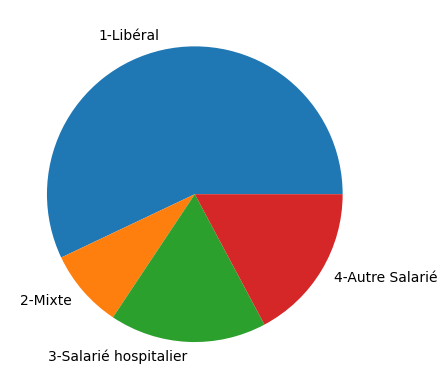

In [ ]:
# On s'intéresse ici au nombre de médecins généralistes selon leur type d'exercice.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']!='0-Ensemble') 
    & (df['tranche_age']=='00-Ensemble') 
    & (df['region'] == '00-Ensemble') 
    & (df['sexe'] == '0-Ensemble')
    & (df['territoire'] == "0-France entière")
] 

labels = df['exercice'].unique()
sizes = df['effectif_2023'].unique()

# Tracé du diagramme.
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)

#### **Sectorisation des médecins en France**

In [151]:
df_medecins_secteur_réduit= df_medecins_secteur[(df_medecins_secteur['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_secteur['region'] == '00-Ensemble')
    & (df_medecins_secteur['departement'] == '000-Ensemble')
    & (df_medecins_secteur['mode_exercice'] == '0-Ensemble')
    & (df_medecins_secteur['territoire'] == '0-France entière')
    & (df_medecins_secteur['specialites'] == '01-Médecine générale')
    ]
df_medecins_secteur_réduit.head()

,territoire,region,departement,mode_exercice,secteur_activite,specialites,specialites_agregees,activités_2012,activités_2013,activités_2014,...,activités_2016,activités_2017,activités_2018,activités_2019,activités_2020,activités_2021,activités_2022,activités_2023,activités_2024,activités_2025
3,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,00-Ensemble,01-Médecine générale,1-Médecine générale,112701,115011,117635,...,121306,122650,124046,124527,125628,126096,126233,126541,129841,131133
21,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,01-Hôpital public,01-Médecine générale,1-Médecine générale,17618,18373,19202,...,19993,20680,21043,21276,21357,21257,21111,20684,20961,21118
39,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,02-Etablissement privé ESPIC,01-Médecine générale,1-Médecine générale,1597,1671,1682,...,1771,1804,1857,1897,1864,1913,1989,1946,2047,2070
57,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,03-Etablissement privé lucratif,01-Médecine générale,1-Médecine générale,1312,1579,1652,...,1918,2000,2098,2187,2251,2279,2290,2335,2402,2434
75,0-France entière,00-Ensemble,000-Ensemble,0-Ensemble,"04-Centre de santé, maison de santé",01-Médecine générale,1-Médecine générale,2792,3228,3480,...,3794,3911,3971,4080,4514,4885,5124,5583,6516,7235


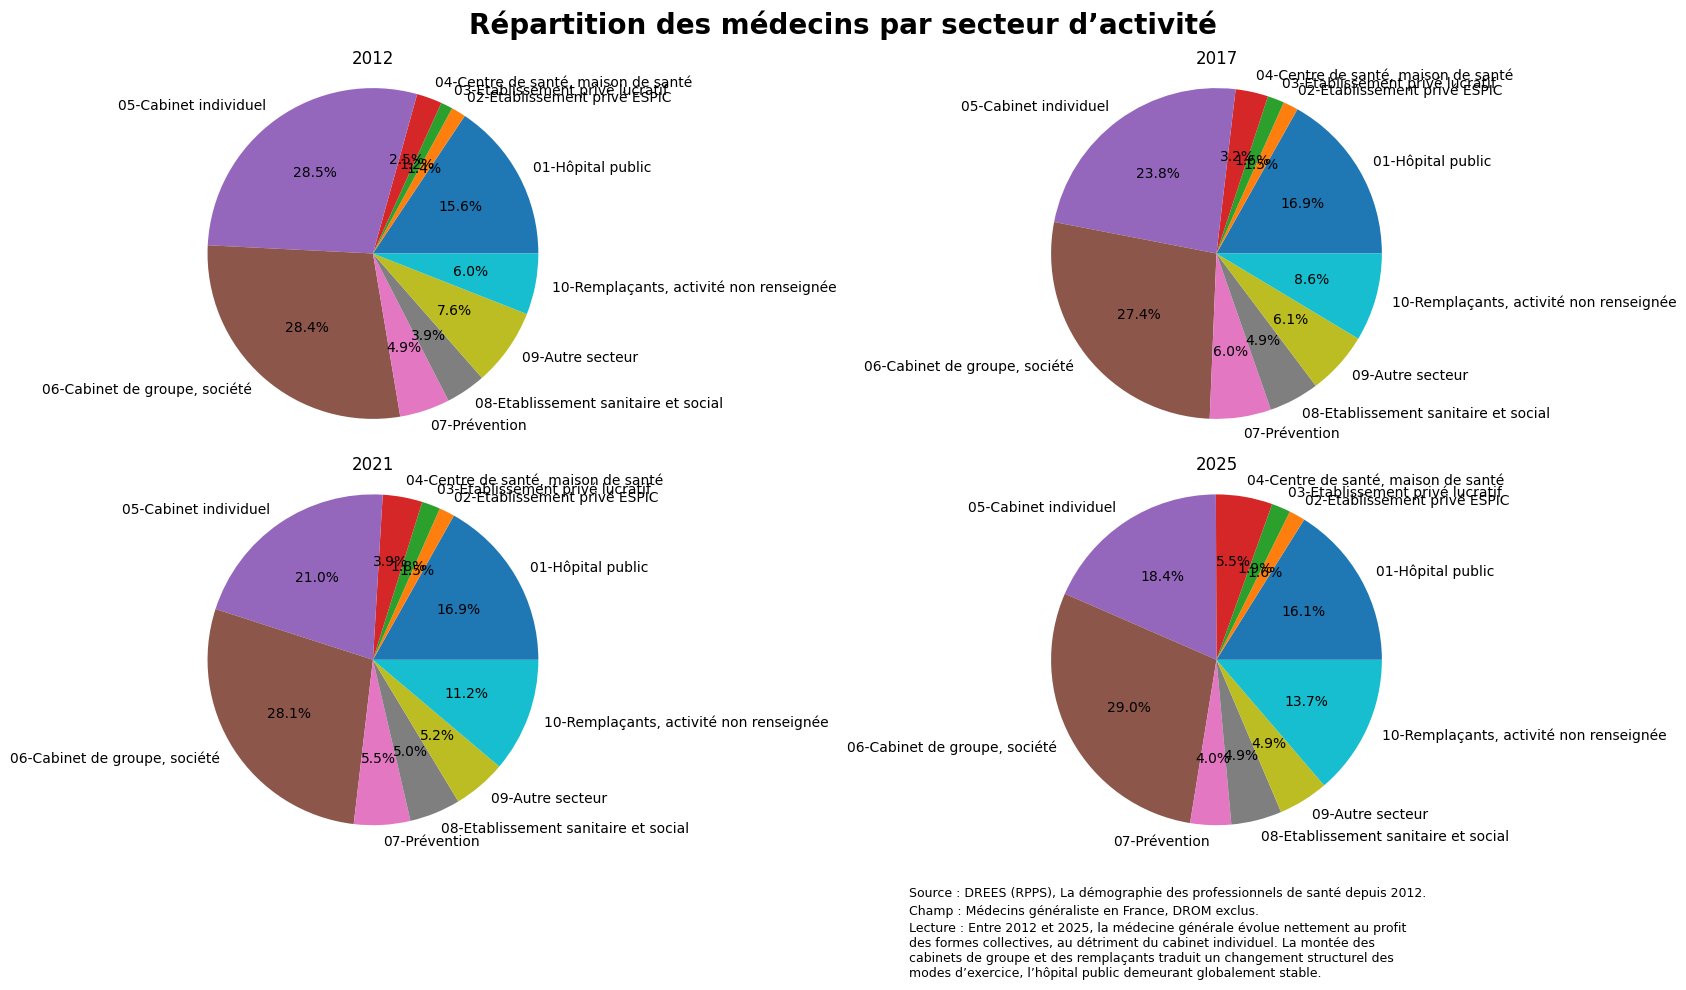

In [152]:
df_medecins_secteur_réduit = df_medecins_secteur_réduit[df_medecins_secteur_réduit["secteur_activite"] != "00-Ensemble"]

# Définition de la figure (répartition & taille)
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

# Tracé des graphes
for axe, annee in zip(axes.flatten(), [2012, 2017, 2021, 2025]):
    plot_camembert(df_medecins_secteur_réduit, annee, axe, 'secteur_activite',f'activités_{annee}')

# Titre
fig.suptitle("Répartition des médecins par secteur d’activité", fontsize=20, fontweight="bold")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généraliste en France, DROM exclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.38,
    "Lecture : Entre 2012 et 2025, la médecine générale évolue nettement au profit\n"
    "des formes collectives, au détriment du cabinet individuel. La montée des\n"
    "cabinets de groupe et des remplaçants traduit un changement structurel des\n"
    "modes d’exercice, l’hôpital public demeurant globalement stable.",
    va="bottom",
    fontsize=9,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()

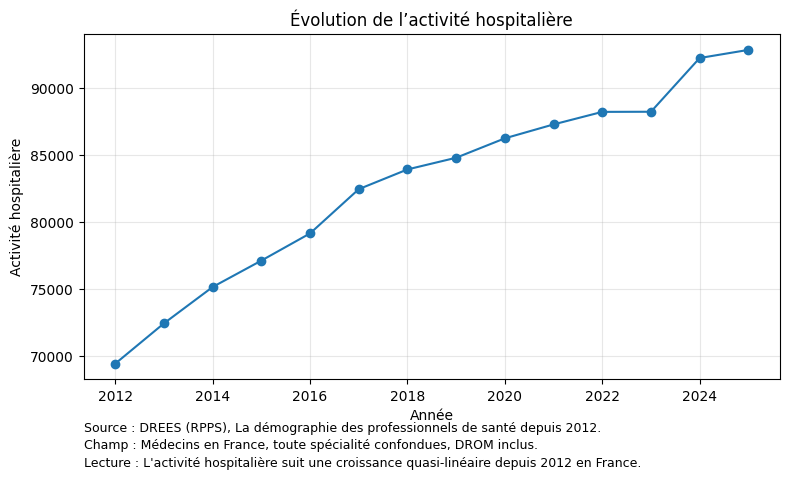

In [153]:
df_hopital = df_medecins_secteur[(df_medecins_secteur["secteur_activite"] == "01-Hôpital public")
    & (df_medecins_secteur["mode_exercice"] == "0-Ensemble")
    & (df_medecins_secteur["departement"] == "000-Ensemble")
    & (df_medecins_secteur["region"] == "00-Ensemble")
    & (df_medecins_secteur["territoire"] == "0-France entière")
    & (df_medecins_secteur["specialites_agregees"] == "00-Ensemble")
    & (df_medecins_secteur["specialites"] == "00-Ensemble")
    ]

# Colonnes d'activité
cols_activite = [c for c in df_hopital.columns if c.startswith("activités_")]

# Années
annees = [int(c.split("_")[1]) for c in cols_activite]


plt.figure(figsize=(8, 5))
plt.plot(annees, df_hopital[cols_activite].iloc[0], marker='o')


plt.xlabel("Année")
plt.ylabel("Activité hospitalière")
plt.title("Évolution de l’activité hospitalière")
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins en France, toute spécialité confondues, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : L'activité hospitalière suit une croissance quasi-linéaire depuis 2012 en France.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### **Spécialisation des médecins en France**

In [154]:
df_medecins_specialité = df_medecins_effectif_complet[(df_medecins_effectif_complet['sexe'] == '0-Ensemble')
    & (df_medecins_effectif_complet['departement'] == '000-Ensemble')
    & (df_medecins_effectif_complet['exercice']=='0-Ensemble') 
    & (df_medecins_effectif_complet['region'] == '00-Ensemble') 
    & (df_medecins_effectif_complet['territoire'] == "0-France entière")
    & (df_medecins_effectif_complet['tranche_age'] == "00-Ensemble")
    & (df_medecins_effectif_complet['specialites'] != '00-Ensemble')
    ]

df_medecins_specialité.drop(axis = 1, columns = ['region','specialites_agregees','sexe', 'tranche_age','territoire','departement','exercice'], inplace = True)
df_medecins_specialité.reset_index(drop = True, inplace = True)
df_medecins_specialité.head()

/tmp/ipykernel_90302/3033301306.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medecins_specialité.drop(axis = 1, columns = ['region','specialites_agregees','sexe', 'tranche_age','territoire','departement','exercice'], inplace = True)


,specialites,effectif_2012,effectif_2013,effectif_2014,effectif_2015,effectif_2016,effectif_2017,effectif_2018,effectif_2019,effectif_2020,effectif_2021,effectif_2022,effectif_2023,effectif_2024,effectif_2025
0,01-Médecine générale,101435,101385,101904,101935,101799,101755,101939,101381,101355,100621,99941,99457,99009,100019
1,02-Chirurgie,11984,12225,12448,12665,12887,13106,13314,13405,13644,13788,13956,13952,14139,14332
2,03-Ophtalmologie,5760,5817,5820,5865,5881,5900,5853,5821,5850,5826,5794,5749,5825,5981
3,04-Oto-rhino-laryngologie,3018,3043,3059,3042,3061,3048,3022,3006,3023,2999,2996,2963,2937,2933
4,05-Anesthésie-Réanimation,10846,11008,11145,11368,11512,11666,11846,11856,12063,12215,12523,12763,13273,13536


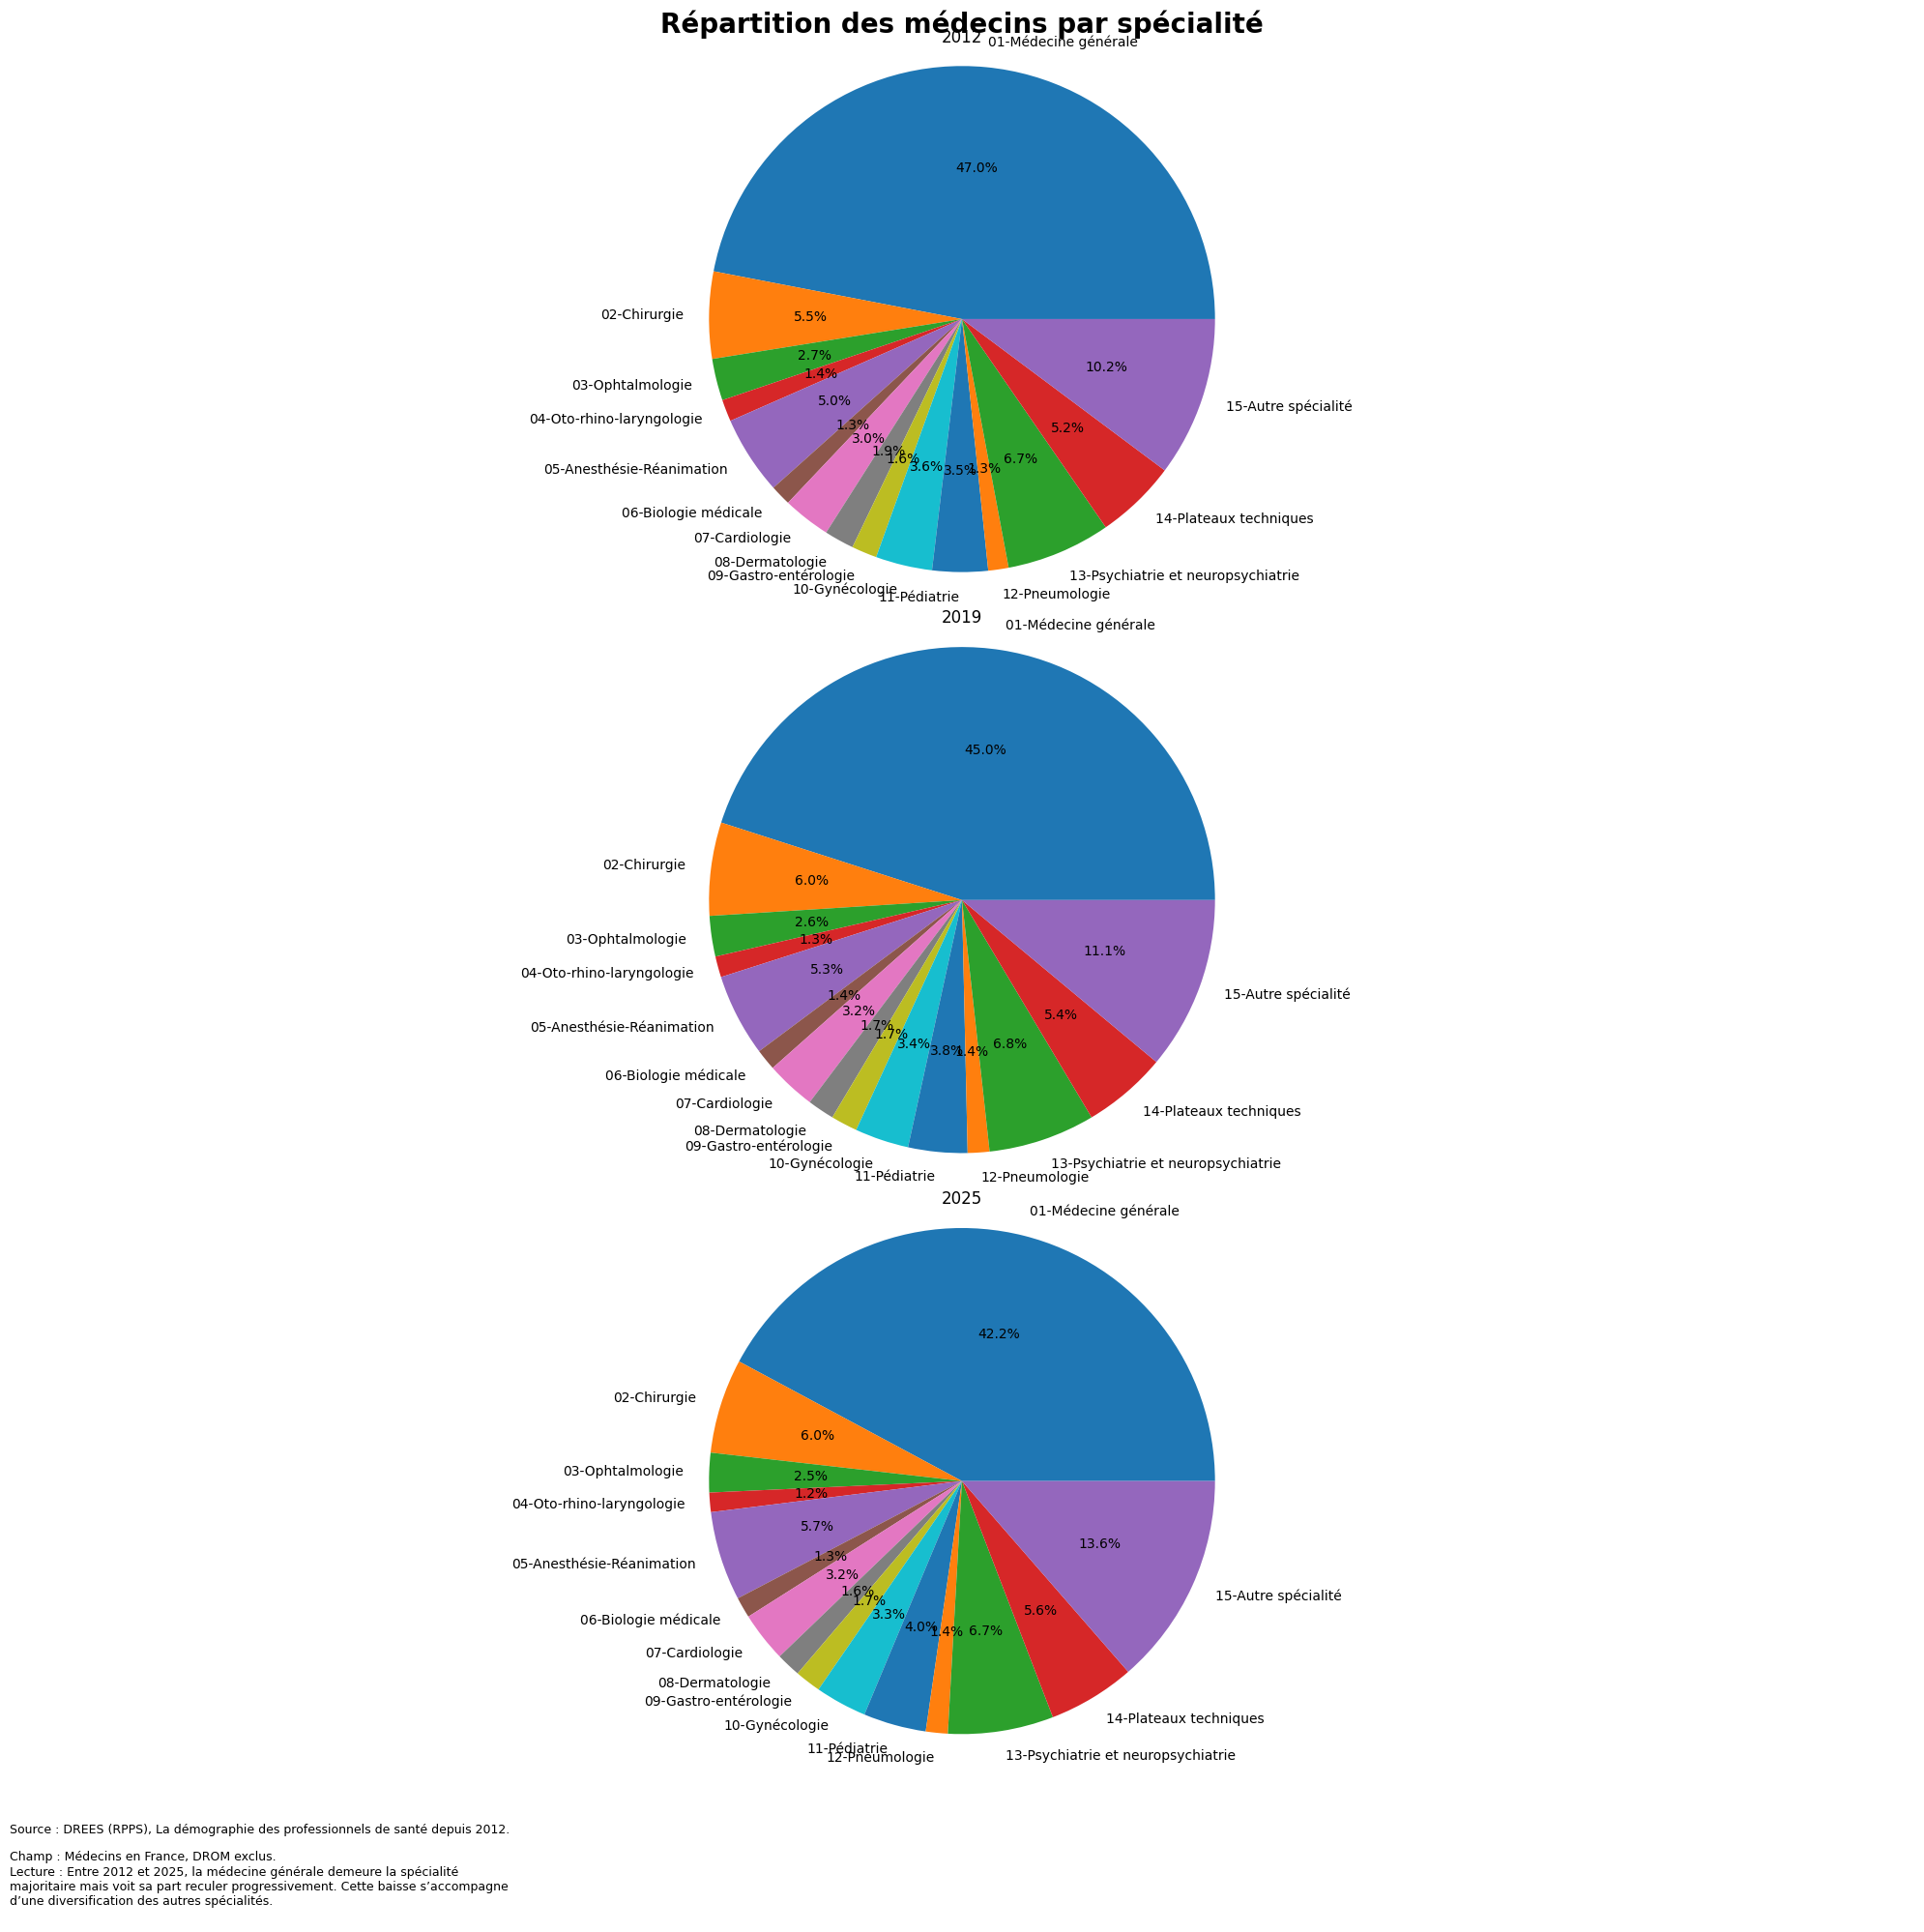

In [155]:
# Définition de la figure (répartition & taille)
fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# Tracé des graphes
for axe, annee in zip(axes, [2012, 2019, 2025]):
    plot_camembert(df_medecins_specialité, annee, axe, 'specialites', f'effectif_{annee}')

# Titre
fig.suptitle("Répartition des médecins par spécialité", fontsize=20, fontweight="bold")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins en France, DROM exclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.32,
    "Lecture : Entre 2012 et 2025, la médecine générale demeure la spécialité \n"
    "majoritaire mais voit sa part reculer progressivement. Cette baisse s’accompagne \n"
    "d’une diversification des autres spécialités.\n",
    va="bottom",
    fontsize=9,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()

### **1.c. Étude géographique de l'offre médicale en France**

#### **Évolution du nombre de médecins généralistes par région**

In [ ]:
# On souhaite étudier l'évolution du nombre de médecis généralistes par région.
# On construit une base de données qui contient les effectifs par région par année.
df = df_MG_effectif.copy()

df = df[
    (df['exercice']=='0-Ensemble')
    & (df['tranche_age']=='00-Ensemble') 
    & (df['sexe']=='0-Ensemble')
    & (df['departement']=='000-Ensemble')
    & (df['region'] != '00-Ensemble')
    ]

df.sort_values('region', inplace=True)
df.reset_index(inplace=True, drop=True)

df

In [ ]:
# 1. Définition des abscisses : années 2012 à 2025.
annees = list(range(2012,2026))

# 2. Définition dune palette avec 20 couleurs de manière à ce que chaque région ait une couleur différente.
plt.gca().set_prop_cycle(color=plt.cm.tab20.colors)

# 3. Définition des ordonnées : effectifs par région des années 2012 à 2025.
for region in df['region'].unique() :
    df_region = df[(df['region'] == region) & (df['departement'] == '000-Ensemble')]
    effectifs = df_region[[f"effectif_{a}" for a in annees]].values.flatten()
    plt.plot(annees, effectifs, label = region, marker = "o")

# 4. Titre et axes. 
plt.xlabel("Année")
plt.ylabel("Nombre de médecins généralistes")
plt.title(f"Évolution du nombre de médecins généralistes par région")

# Légende.
plt.legend(title="Région", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes par région en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en Île de France est passé d'environ 18 500 en 2012 à 16 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

## **2. Étude de la répartition des déserts médicaux**

### **1.a. Étude de la densité de médecins en France**

#### **Densité de médecins généralistes par département en 2023**

In [105]:
# On fait une base de données qui nous donne la densité par département et par année.
df = df_MG_densite.copy()
df = df[(
    df['departement'] != '000-Ensemble') 
    & (df['tranche_age'] == '00-Ensemble')
    & (df['exercice'] == '0-Ensemble')
]

df.reset_index(inplace = True, drop = True)

# On recode la variable du département pour ne garder que le code.
df['departement'] = df['departement'].astype(str).str[:3]

# On recode la variable du département de la base cartiflette pour que les codes correspondent.
departements = gdf_departements.copy()
departements['INSEE_DEP'] = departements['INSEE_DEP'].str.zfill(3)

In [ ]:
# Jointure des deux bases sur la clé du code du département.
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

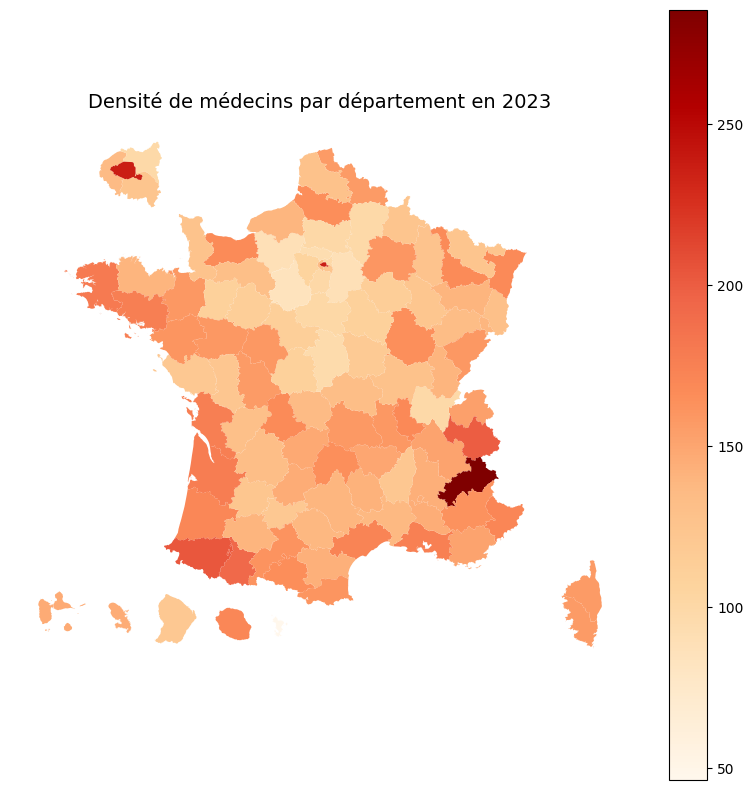

In [107]:
# Tracé de la carte.
fig, ax = plt.subplots(figsize=(10,10))

departements.plot(
    ax=ax,
    column="densite_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

ax.axis("off")
ax.set_title("Densité de médecins par département en 2023", fontsize=14)

plt.show()

#### **Densité de médecins généralistes par commune en 2024**

In [113]:
# On utilise ici la base des données communales pour avoir la densité par commune.
df = df_pop_communes.copy()
communes = gdf_communes.copy()

# Jointure des bases sur la clé du code de la commue.
communes = communes.merge(df, right_on = 'Code', left_on = 'INSEE_COM')

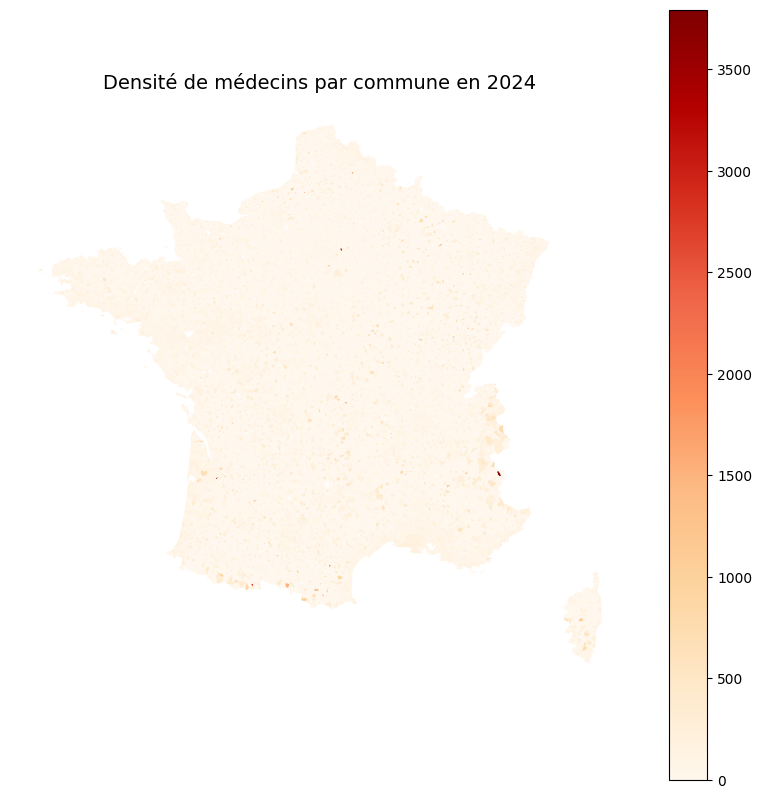

In [ ]:
# Tracé de la carte des densités. 
fig, ax = plt.subplots(figsize=(10,10))

# 1. Tracé de la carte.
communes.plot(
    ax=ax,
    column="Densité médecins généralistes 2024",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

# 2. Titre.
ax.axis("off")
ax.set_title("Densité de médecins par commune en 2024", fontsize=14)

plt.show()

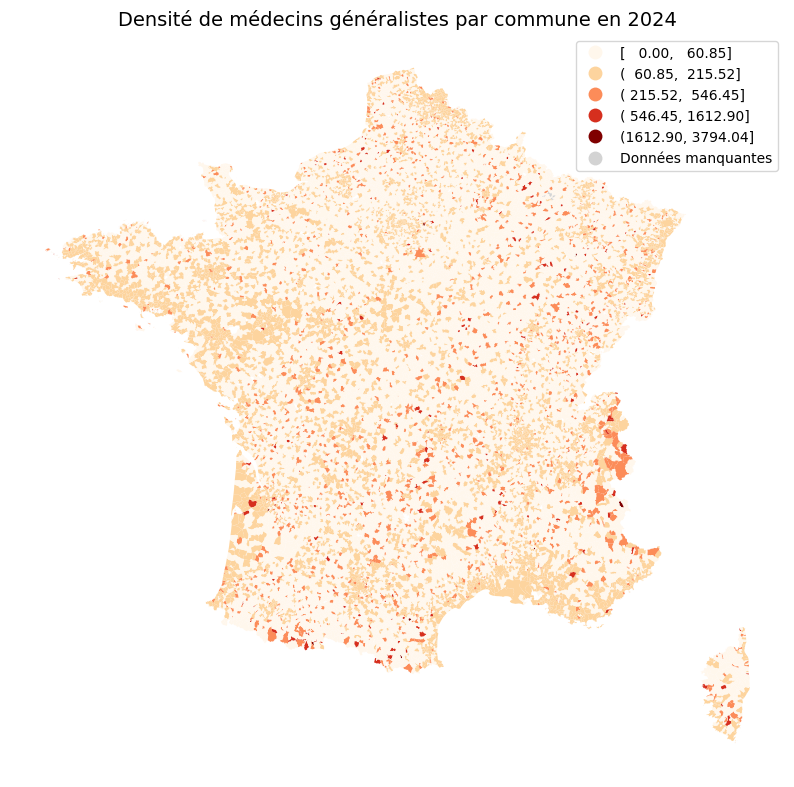

In [ ]:
# On constate que certaines valeurs trop importantes empêchent de voir les disparités de densité
# au niveau communal. On utilise NaturalBreaks pour identifier des groupes de densités semblables.
fig, ax = plt.subplots(figsize=(10,10))

# 1. On choisit le nombre de groupes.
n = 5

# 2. Tracé de la carte.
communes.plot(
    ax=ax,
    column="Densité médecins généralistes 2024",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
    scheme = "NaturalBreaks",
    k = n, 
)

# 3. Titre.
ax.axis("off")
ax.set_title("Densité de médecins généralistes par commune en 2024", fontsize=14)

# 4. Légende.
# On affiche les intervalles de valeurs correspondant à chaque groupe.
q = mapclassify.NaturalBreaks(communes['Densité médecins généralistes 2024'].dropna(), k=n)
mapping = {i: s for i, s in enumerate(q.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()


### **1.b. Étude de l'indicateur APL en France**

#### **Cartographie de l'indicateur APL par département en 2023**

In [128]:
# On ne s'intéresse ici qu'à l'indicateur au niveau agrégé du département : on ne conserve qu'une ligne par département.
df = df_APL.copy()
df.drop_duplicates('departement', inplace = True)

departements = gdf_departements.copy()

# Jointure des deux tables sur la clé du code du département.
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

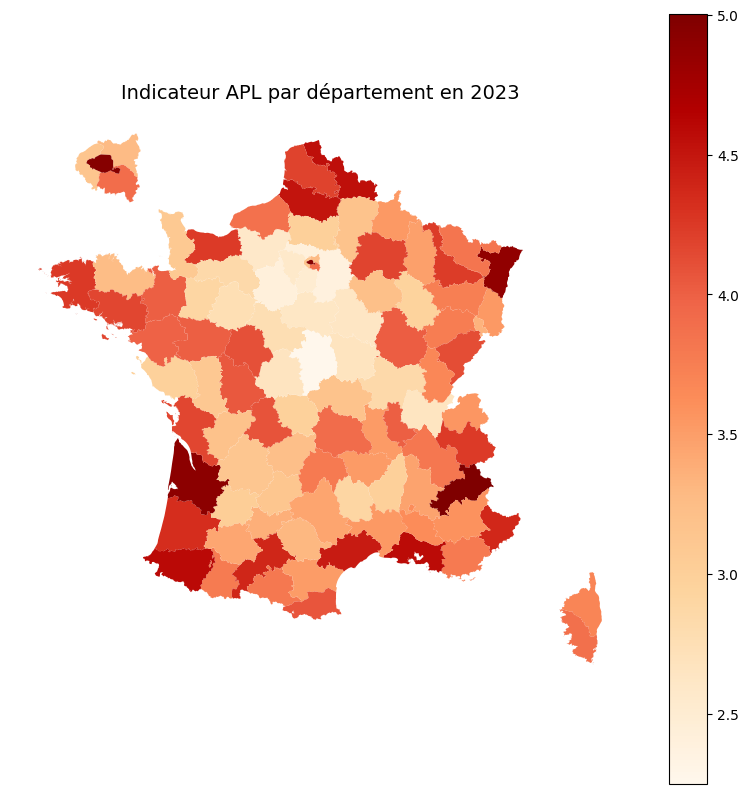

In [129]:
fig, ax = plt.subplots(figsize=(10,10))

# 1. Tracé de la carte.
departements.plot(
    ax=ax,
    column="APL_dep_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

# 2. Titre.
ax.axis("off")
ax.set_title("Indicateur APL par département en 2023", fontsize=14)

plt.show()

#### **Cartographie de l'indicateur APL par commune en 2023**

In [116]:
df = df_APL.copy()
communes = gdf_communes.copy()

# Jointure des deux bases sur la clé du code de la commune.
communes = communes.merge(df, left_on = "INSEE_COG", right_on = "Code commune INSEE", how="left")
communes = communes.to_crs(2154)

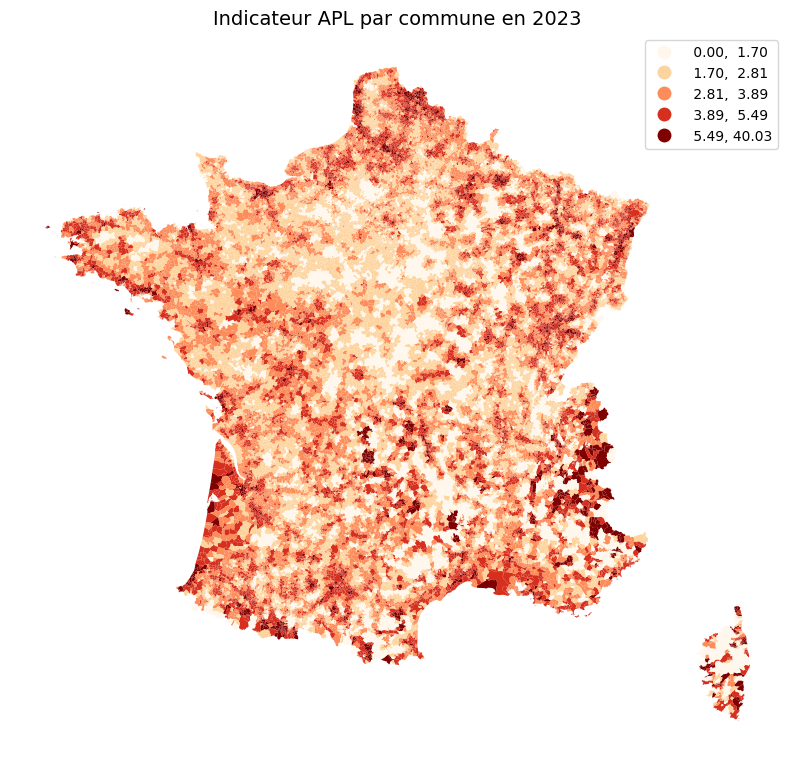

In [149]:
# Ici encore, on décide d'utiliser NaturalBreaks pour éviter que certaines valeurs trop importantes
# de l'indicateur ne rendent difficile la lecture de la carte.
fig, ax = plt.subplots(figsize=(10,10))

# 1. On choisit le nombre de groupes. 
n = 5

# 2. Tracé de la carte.
communes.plot(
    ax=ax,
    column="APL_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
    scheme = "NaturalBreaks",
    k = n
)

# 3. Titre.
ax.axis("off")
ax.set_title("Indicateur APL par commune en 2023", fontsize=14)

# 4. Légende.
q = mapclassify.NaturalBreaks(communes['APL_2023'].dropna(), k=n)
mapping = {i: s for i, s in enumerate(q.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()

### **1.c. Étude de la patientèle des médecins généralistes en France**

#### **Cartographie du nombre de patients uniques par médecin selon le département en 2023**

In [145]:
# On s'intéresse à la patientèle des médecins généralistes pour l'année 2023, afin d'être comparable à nos autres cartes.
df = df_patientele.copy()
departements = gdf_departements.copy()

df = df[
    (df['annee'] == 2023)
    & (df['profession_sante'] == 'Ensemble des médecins généralistes')]

# On supprime les lignes qui ne correspondent pas à des départements français.
mask = df['departement'].isin(['999'])
df = df[~mask]
df.reset_index(drop = True, inplace = True)

# Jointure des bases de données sur la clé du code du département.
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

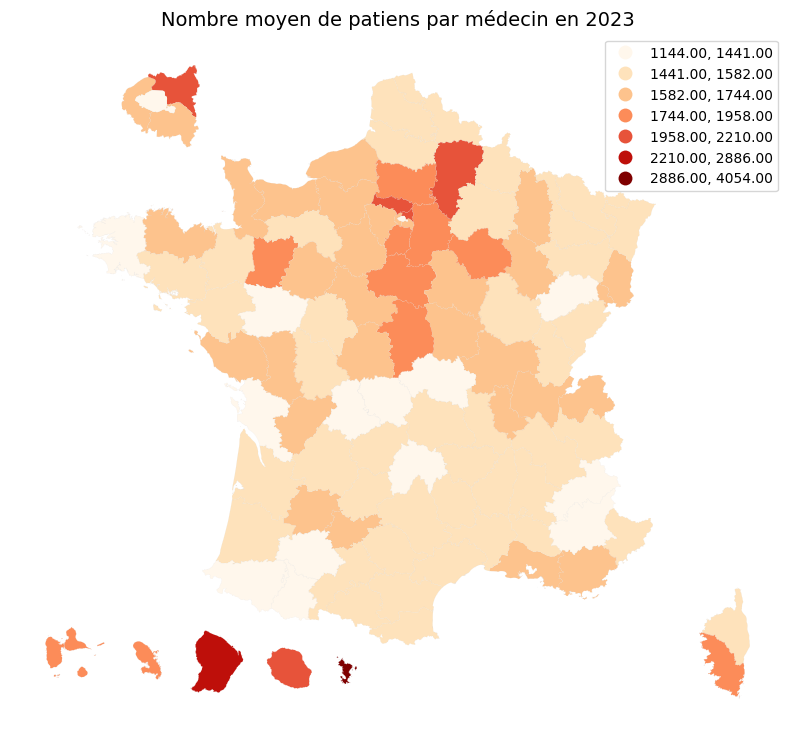

In [150]:
fig, ax = plt.subplots(figsize=(10,10))

# 1. Choix du nombre de groupes
n = 7

# 2. Tracé de la carte.
departements.plot(
    ax=ax,
    column="nombre_patients_uniques",
    cmap="OrRd",               
    linewidth=0.05,
    legend=True,
    scheme = 'NaturalBreaks',
    k=n,
    edgecolor="lightgrey", 
)

# 3. Titre.
ax.axis("off")
ax.set_title("Nombre moyen de patiens par médecin en 2023", fontsize=14)

# 4. Légende.
q = mapclassify.NaturalBreaks(communes['APL_2023'].dropna(), k=n)
mapping = {i: s for i, s in enumerate(q.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()

# **III. Modélisation**

## **1. Régression du nombre de médecins par commune en fonction des indicateurs communaux**

In [ ]:
# Fonction pour faire une matrice de corrélation des variables.
def plot_corr_heatmap(
    df: pd.DataFrame,
    drop_cols=None,
    column_labels: dict | None = None,
    decimals: int = 2,
    width: int = 600,
    height: int = 600,
    show_xlabels: bool = False
):
    data = df.copy()

    # 1. Colonnes à drop
    if drop_cols is not None:
        data = data.drop(columns=drop_cols)

    # 2. Arrondi + renommage éventuel
    if column_labels is not None:
        data = data.rename(columns=column_labels)
    data = data.round(decimals)

    # 3. Matrice de corrélation
    corr = data.corr()

    # 4. Masque triangle supérieur
    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr_masked = corr.mask(mask)

    # 5. Heatmap Plotly
    fig = px.imshow(
        corr_masked.values,
        x=corr.columns,
        y=corr.columns,
        color_continuous_scale='RdBu_r',  # échelle inversée
        zmin=-1,
        zmax=1,
        text_auto=".2f"
    )

    # 6. Hover custom
    fig.update_traces(
        hovertemplate="Var 1: %{y}<br>Var 2: %{x}<br>Corr: %{z:.2f}<extra></extra>"
    )

    # 7. Layout
    fig.update_layout(
        coloraxis_showscale=False,
        xaxis=dict(
            showticklabels=show_xlabels,
            title=None,
            ticks=''
        ),
        yaxis=dict(
            showticklabels=show_xlabels,
            title=None,
            ticks=''
        ),
        plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(t=10, b=10, l=10, r=10),
        width=width,
        height=height
    )

    return fig

In [ ]:
# Fonction pour extraire les coefficients sélectionnés par Lasso.
def extract_features_selected(lasso: Pipeline, preprocessing_step_name: str = 'preprocess') -> pd.Series:
    # Check if lasso object is provided
    if not isinstance(lasso, Pipeline):
        raise ValueError("The provided lasso object is not a scikit-learn pipeline.")
    
    # Extract the final transformer from the pipeline
    lasso_model = lasso[-1]

    # Check if lasso_model is a Lasso regression model
    if not isinstance(lasso_model, Lasso):
        raise ValueError("The final step of the pipeline is not a Lasso regression model.")

    # Check if lasso model has 'coef_' attribute
    if not hasattr(lasso_model, 'coef_'):
        raise ValueError("The provided Lasso regression model does not have 'coef_' attribute. "
                         "Make sure it is a trained Lasso regression model.")

    # Get feature names from the preprocessing step
    features_preprocessing = lasso[preprocessing_step_name].get_feature_names_out()

    # Extract selected features based on non-zero coefficients
    features_selec = pd.Series(features_preprocessing[np.abs(lasso_model.coef_) > 0])

    return features_selec